# Waterloo SQoE-III Analysis
https://ece.uwaterloo.ca/~zduanmu/tbc2018qoe/ A Quality-of-Experience Database for Adaptive Video Streaming. Zhengfang Duanmu University of Waterloo, Abdul Rehman University of Waterloo, Zhou Wang University of Waterloo

The database contains 20 source sequences of various types of content and 450 streaming videos generated using 6 ABR algorithms in 13 different and representative network conditions.

The original dataset is organized in the form of Matlab code, it was necessary to transform it into a table. I have done it. You can find it at the dirrectory waterloo_sqoe_3_data. 

The first part is devoted to preprocessing the raw features, adding features from the article to it. The result is a table of characteristics and a target value MOS.

In the second part, a statistical analysis of features is carried out and the most and the leas important fratures are founded.

The third part is devoted to the construction of models and their analysis. 

In [367]:
import scipy.io

import pandas as pd
import numpy as np
import statistics

import math
import seaborn as sns

import statistics

import re 
from scipy.stats import spearmanr

from platform import python_version
print(python_version())

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

from itertools import combinations_with_replacement, combinations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

3.7.4


In [368]:
full = pd.read_excel('Full_true.xlsx',index_col=0)
full.head(2)

,Name,FPS,stallTime,duration,switching,SwithcingMagnitide,bitrates,seqPSNR per frame,initial buffer time,duration of stalling events in second,Rebuffer count,average duration of stalling event,mean(seqPSNR),MOS,Representation 1,Representation 2,Representation 3,Representation 4,Representation 5,averageWeightedBitrate
0,BigBuckBunny,30,4.03330,14.0333,[false. false. false. false],NaN,222 222 222 222 222,23.2066 23.1989 23.1793 23.1564...,1.80000,0.73333 1.0667 0.43333,3,0.74444,27.5826,31.376990,320x240_fps30_420_235k,320x240_fps30_420_235k,320x240_fps30_420_235k,320x240_fps30_420_235k,320x240_fps30_420_235k,222.0
1,BigBuckBunny,30,0.53333,10.5333,[false. true. true. true],121 181 241,222 222 524 696 974,23.2066 23.1989 23.1793 23.1564...,0.53333,NaN,0,0.00000,29.5138,51.006205,320x240_fps30_420_235k,320x240_fps30_420_235k,512x384_fps30_420_560k,512x384_fps30_420_750k,640x480_fps30_420_1050k,527.6


## Features adding: simple features from the initial paper
Adding features SI/TI from data description (spatial and temporal information) This is some meatrics, recommended by ITU, that help to describe complexiry of the data Below, at the part of data analysis, you will see that they are not valid

In [369]:
siti = np.array([["BigBuckBunny",       96 ,97, "animation", "high motion"],
                 ["BirdOfPrey",         44 ,68, "nature","smooth motion"], 
                 ["Cheetah",            64, 37, "animals","camera motion"],
                 ["CostaRica",          45, 52, "natue","smooth motion"], 
                 ["CSGO",               70 ,52, "game","average motion"], 
                 ["FCB",                 80,46, "sports","average motion"], 
                 ["FrozenBanff",       100 ,88, "nature","smooth motion"], 
                 ["Mtv",               112,144, "human","average motion"], 
                 ["PuppiesBath",        35 ,45, "animals","smooth motion"],
                 ["RoastDuck",          60 ,84, "food","smooth motion"],
                 ["RushHour",           52 ,20, "human","smooth motion"],
                 ["Ski",                61 ,82, "sports","high motion"],
                 ["SlideEditing",      160 ,86, "screen","smooth motion"],
                 ["TallBuildings",      81 ,13, "architecture","static"],
                 ["TearsOfSteel1",      53 ,66, "movie","smooth motion"],
                 ["TearsOfSteel2",      56 ,11, "movie","static"],
                 ["TrafficAndBuilding", 66 ,15, "architecture","static"],
                 ["Transformer",        72 ,56, "movie","average motion"],
                 ["Valentines",          40,52, "human","smooth motion"],
                 ["ZapHighlight",        97,89, "animation","high motion"]], dtype = object)
print (len(siti[:,0]))

20


In [370]:
cols = ["Name", "SI","TI","content", "motion"]
video_descr = pd.DataFrame(data=siti, columns = cols)
video_descr.head (2)

,Name,SI,TI,content,motion
0,BigBuckBunny,96,97,animation,high motion
1,BirdOfPrey,44,68,nature,smooth motion


Let's see on Spatio-Temporal complexity space. Dot density is low but fairly uniform

Text(0, 0.5, 'Spatial informationl')

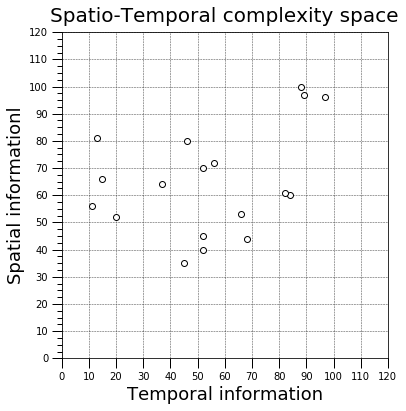

In [371]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect=1)


def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x

ax.xaxis.set_major_locator(MultipleLocator(10.000))
ax.xaxis.set_minor_locator(AutoMinorLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(10.000))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_minor_formatter(FuncFormatter(minor_tick))

ax.set_xlim(0, 120)
ax.set_ylim(0, 120)

ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', width=1.0, labelsize=10)
ax.tick_params(which='minor', length=5, labelsize=10, labelcolor='0.25')

ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

X = video_descr ["TI"]
Y = video_descr ["SI"]

ax.plot(X, Y, linewidth=0,
        marker='o', markerfacecolor='w', markeredgecolor='k')

ax.set_title("Spatio-Temporal complexity space", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("Temporal information", fontsize=18)
ax.set_ylabel("Spatial informationl", fontsize=18)

Adding SI and TI to the dataset

In [372]:
full["SI"] = full["TI"] = full["content"] = full["motion"] = np.nan

for index, row in full.iterrows():
    for i in range (0, 20, 1):
        if row ["Name"] == siti[i][0]:
            full.loc[index,"SI"] = siti[i][1]
            full.loc[index,"TI"] = siti[i][2]
            
            full.loc[index,"content"] = siti[i][3]
            full.loc[index,"motion"] = siti[i][4]

 We have a lot of string data type with various amount of spaces. It's not very good code, I know

In [373]:
def list_to_float (value, separator = " "):
    if str(value) == 'nan':
        return 0         
    value = value.replace('         ', ' ')         
    value = value.replace('    ', ' ')
    value = value.replace('   ', ' ')
    value = value.replace('  ', ' ')
    
    value = value.split(separator)
    value = list(map(lambda x : float(x), value))
    return value

In [374]:
for index, row in full.iterrows():
    value = list_to_float(row['duration of stalling events in second'])
    full.at[index, 'duration of stalling events in second']= value
    value = list_to_float(row['bitrates'])
    full.at[index, 'bitrates'] = value
    
    value = list_to_float(row['SwithcingMagnitide'])
    full.at[index, 'SwithcingMagnitide'] = value
    
    value = list_to_float(row['seqPSNR per frame'])
    full.at[index, 'seqPSNR per frame'] = value

## MOS and others - distributions
Firts, let's calculate number of stalling events and show what data we have

In [375]:
st_events = []

for index, row in full.iterrows():
    value = row['duration of stalling events in second']
    if (type (value) == int):
        pass
    elif (type (value) == list):
        for i in range (0, len(value),1):
            st_events.append (value[i])

In [376]:
def statistics_plot (data):
    df = pd.DataFrame({"col": data})

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df["col"].mean()
    median=df["col"].median()
    #mode=df["stalling events"].mode().get_values()[0]
    mode=df["col"].mode()[0]

    sns.boxplot(df, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.distplot(df, ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    ax_hist.axvline(mode, color='b', linestyle='-')

    plt.legend({'Mean':mean,'Median':median,'Mode':mode}, fontsize = 12)

    print ("mean:",mean, "median:", median,"mode:", mode)
    
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    #ax.set_xlabel("MOS", fontsize=18)
    #ax.set_ylabel("Distribution", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax_box.set(xlabel='')
    plt.show()

The MOS distribution is normal. For us, this means that we can apply correlation coefficients that require a normal distribution of the quantity.

I will write in more detail about the correlation coefficients separately.

mean: 60.866948018124475 median: 62.2687466098366 mode: 11.684961984291197


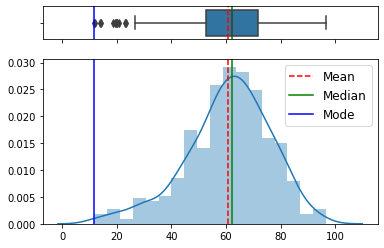

In [377]:
statistics_plot (full['MOS'])

mean: 1.323634188405796 median: 0.8 mode: 0.16667


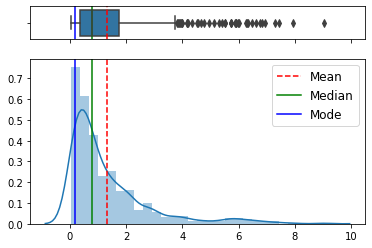

In [378]:
statistics_plot (st_events)

In [379]:
all_psnr = []

for index, row in full.iterrows():
    value = row['seqPSNR per frame']
    for i in range (0, len(value),1):
        all_psnr.append (value[i])

Therefore, PSNR distribution has gaussian behaviour.
Using such simple and non-human vision orientated metric as the only one parameter in QoE calculation is ambiguous.
But first, we have this data and second, a few simple metrics can be used to create a hybrid model. These simple metrics will capture specific features and together produce great results.

mean: 36.20173993328256 median: 36.2769 mode: 60.0


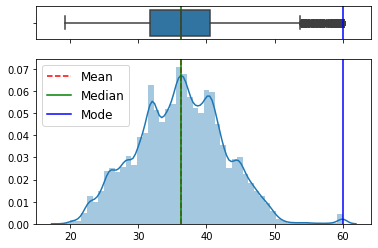

In [380]:
statistics_plot (all_psnr)

We also can calculate median/mean/mode values and choose what is better in terms of correlation with MOS

In [381]:
def mediana(items):
    if (type (items) == int):
        return items
    else:
        return statistics.median(map(float, items))
    
def mean(items):
    return statistics.mean(items)

def maximum(items):
    if (type (items) == int):
        return items
    else:
        return max(items)

In [382]:
full["st_events_median"] = full["SwithcingMagnitide_median"] = np.nan
full["st_events_max"] = full["SwithcingMagnitide_max"] = np.nan
full["median(PSNR)"] = np.nan

for index, row in full.iterrows():
    
    value = mediana(row['duration of stalling events in second'])
    full.at[index, 'st_events_median']= value
    
    value = maximum(row['duration of stalling events in second'])
    full.at[index, 'st_events_max'] = value
    
    value = mediana(row['SwithcingMagnitide'])
    full.at[index, 'SwithcingMagnitide_median']= value
        
    value = maximum(row['SwithcingMagnitide'])
    full.at[index, 'SwithcingMagnitide_max'] = value
    
    value = mediana(row['seqPSNR per frame'])
    full.at[index, 'median(PSNR)'] = value

Let's parse the names of the video sessions and extract data from them. Further, the maximum, average and median are calculated for analysis. As shown by the correlation analysis, the mean values give a large Spearman correlation with the MOS, so the median was immediately crossed out. If you want to check, you can uncomment the code.

In [383]:
#640x480_fps30_420_1050k - width/height/frameRate(fps)/dash_bitrate 

def represent_parse(r1, r2, r3, r4, r5):
    width = []
    heigth = []
    dash_bitrate = []
    for r in [r1, r2, r3, r4, r5]:
        parse = re.findall(r'\d+', r)
        width.append (parse[0])
        heigth.append (parse[1])
        dash_bitrate.append (parse[4])
    return width, heigth, dash_bitrate

In [384]:
#Spesial for width and heigth
def list_to_float1 (value, separator = " "):
    if str(value) == 'nan':
        return 0         

    value = list(map(lambda x : float(x), value))
    return value

I have commented the less important features in terms of correlation 

In [385]:
full["width"] = np.nan
full["heigth"] = np.nan
full["dash_bitrate"] = np.nan

#full["median(width)"] = np.nan
#full["median(heigth)"] = np.nan
full["median(dash_bitrate)"] = np.nan

full["mean(width)"] = np.nan
full["mean(heigth)"] = np.nan

for index, row in full.iterrows():
    width, heigth, dash_bitrate, = represent_parse(row["Representation 1"], row["Representation 2"],
                                                   row["Representation 3"], row["Representation 4"], 
                                                   row["Representation 5"])
    full['width'] = full['width'].astype(object)
    full['heigth'] = full['heigth'].astype(object)
    full['dash_bitrate'] = full['dash_bitrate'].astype(object)
    full.iat[index, full.columns.get_loc('width')] = width
    full.iat[index, full.columns.get_loc('heigth')] = heigth
    full.iat[index, full.columns.get_loc('dash_bitrate')] = dash_bitrate
    #full.iat[index, full.columns.get_loc('dash_bitrate')] = list_to_float( dash_bitrate)
    #full.at[index, 'width'] = width
    #full.at[index, 'heigth'] = heigth
    #full.at[index, 'dash_bitrate'] = dash_bitrate
    
    #full.at[index, 'median(width)'] = mediana (width)
    #full.at[index, 'median(heigth)'] = mediana (heigth)
    full.at[index, 'median(dash_bitrate)'] = mediana (dash_bitrate)
    
    #print (width)
    
    full.at[index, 'mean(width)'] = mean (list_to_float1 (width))
    full.at[index, 'mean(heigth)'] = mean (list_to_float1 (heigth))

To choose one we can use Speraman correlation coefficient.

You can see more [here](https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8)

In [386]:
print(spearmanr(full['MOS'], full['mean(width)']))
#print(spearmanr(full['MOS'], full['median(width)']))

SpearmanrResult(correlation=0.5411586048408995, pvalue=1.3510073006092995e-35)


I decided to study the up and down quality switching separately. The hypothesis is that a downward improvement in quality worsens perceptual quality more than a downward improvement in quality. And yes, you are reading correctly that improving quality can degrade the quality of perception.

An analysis of the median and mean was also performed.

In [387]:
def bitates_search (bitrates):
    diff = np.diff (bitrates)

    neg_list = []
    pos_list = []
    for i in diff:
        if i < 0:
            neg_list.append(i)
        elif i > 0:
            pos_list.append(i)
    
    if len (pos_list)!=0:
        maxpos = max(pos_list)
        medpos = mediana (pos_list)
        meanpos = mean (pos_list)
    else:
        maxpos = 0 #In general, this is a good question, how to analyze correctly without quality change
        medpos = 0
        
        meanpos = 0
    if len (neg_list)!=0:
        maxneg = min(neg_list)
        medneg = mediana (neg_list)
        
        meanneg = mean (neg_list)
    else:
        maxneg = 0 
        medneg = 0
        meanneg = 0
            
    return len (pos_list), len(neg_list), maxpos, medpos, maxneg, medneg, meanneg, meanpos

In [388]:
full["bitrate_pos_changes_count"] = np.nan
full["bitrate_neg_changes_count"] = np.nan
full["bitrate_max_pos_change"] = np.nan
full["bitrate_max_neg_change"] = np.nan
#full["bitrate_med_pos_change"] = np.nan
#full["bitrate_med_neg_change"] = np.nan

full["bitrate_mean_pos_change"] = np.nan
full["bitrate_mean_neg_change"] = np.nan

for index, row in full.iterrows():
    pos_count, neg_count, maxpos, medpos, maxneg, medneg, meanneg, meanpos = bitates_search(row['bitrates'])
    
    full.at[index, 'bitrate_pos_changes_count'] = pos_count
    full.at[index, 'bitrate_neg_changes_count'] = neg_count
    full.at[index, 'bitrate_max_pos_change'] = maxpos
    full.at[index, 'bitrate_max_neg_change'] = maxneg
    #full.at[index, 'bitrate_med_pos_change'] = medpos
    #full.at[index, 'bitrate_med_neg_change'] = medneg
    
    full.at[index, 'bitrate_mean_pos_change'] = meanpos
    full.at[index, 'bitrate_mean_neg_change'] = meanneg

In [389]:
#print(spearmanr(full['MOS'], full['bitrate_med_neg_change']))
print(spearmanr(full['MOS'], full['bitrate_mean_neg_change']))

SpearmanrResult(correlation=0.16719319240251546, pvalue=0.0003681222999718926)


## Feature engineering
I have extracted and normilized features from the dataset in such a way

In [390]:
#1. switching / Amount of quality switches
def number_of_sw (switching):
    return  switching.count('true')

#2. Freqency of quality switches
def freq_of_sw (switching, duration):
    #print (switching)
    #print (duration)
    return  switching/duration

#2. Frequency of stalling events
def freq_of_st (stalling_events, duration):
    #print (switching)
    #print (duration)
    return  stalling_events/duration

In [391]:
#Adding Switching Frequency and Switching Type
full["freq_of_st"] = np.nan
full["Bitrate switch count"] = np.nan
full["freq_of_sw"] = np.nan

for index, row in full.iterrows():
    value = freq_of_st(row['Rebuffer count'], row['duration'])
    full.at[index, 'freq_of_st'] = value
    
    value = number_of_sw(row['switching'])
    full.at[index, 'Bitrate switch count'] = value
    
    value = freq_of_st(number_of_sw(row['switching']), row['duration'])
    full.at[index, 'freq_of_sw'] = value

In [392]:
full["median(bitrates)"] = np.nan

for index, row in full.iterrows():
    value = mediana(row['bitrates'])
    full.at[index, 'median(bitrates)'] = value

# Features adding: common/industrial metrics from the paper

In this section, we repeat the result suggested in the original article.
In fact, in two signs, I got different levels of correlation, but this prompted the idea to explore them in more detail and interesting results were obtained.

**The percentage of rebuffering** (**Pr**). 

This metric is the fraction of session time (replay plus rebuffering) spent buffering. This is a cumulative metric that can account for the periods of "freeze" video seen by the user.

In [393]:
#Rebuffer percentage
full["Rebuffer percentage"] = np.nan

for index, row in full.iterrows():
    #value = row['stallTime']/ row['duration']
    value = (row['stallTime'] -row['initial buffer time'])/ (row['duration'] -row['initial buffer time'])
    full.at[index, 'Rebuffer percentage'] = value

In [394]:
print(spearmanr(full['MOS'], full['Rebuffer percentage']))

SpearmanrResult(correlation=-0.27325064979898134, pvalue=3.794375770804499e-09)


**Average rendered bitrate**

Calculated in Kilobytes / s, weighted average playable bitrate, calculated taking into account the duration of each playable bitrate.

Fortunately, I found it in the original data of the matlab's dataset description.

**Number of bitrate switches**

There can be many bitrate switches in one streaming session. The number of flickers is commonly used to quantify the "flicker effects" represented by the variation in quality.
 
Here, apparently, it makes sense to use the normalized number, that is, the frequency of bitrate switching. And it's already done

But let's leave this parameter right now

**Average bit rate switching**

Measured in kilobytes / switch. This metric is also a factor in the flicker effect. The conventional wisdom is that people prefer multiple switches with small bitrate differences over sharp changes in quality.

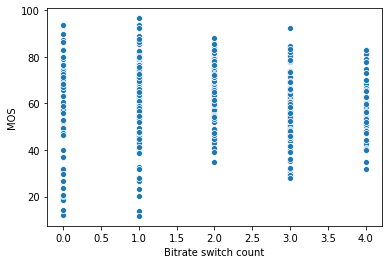

In [395]:
sns.scatterplot(y="MOS", x="Bitrate switch count", ci=None, data=full)

# DASH-level vs ground truth bitrate

An interesting point is the correspondence between the quality level of the codec (bitrate dash) and the actual bandwidth.

In a real dataset, these parameters coincide with an accuracy of tens of kilobits / s. It is quite simple to check this - to evaluate the mutual correlation of features built on the data of the real bitrate and DASH-bitrate. Or display graphs, of course
This means that under the experimental conditions, the adaptive algorithms have worked out the strategy of matching the current bandwidth.

There are other strategies as well. So, the video quality could lag behind the current bitrate by one or several levels, but there would be a margin in the buffer and this method would reduce quality switching and the number of fading events.

In further experiments with building datasets, it makes sense to consider a wider list of network states so that different ABS algorithms show qualitatively different behavior.

In [396]:
def dash_change_count(dash):
    sum_index = 0
    for i in range(0, len(dash) - 1):
        if int(dash[i]) != int(dash[i + 1]):   
            sum_index += 1
    return sum_index

In [397]:
full["dash_change_count"] = np.nan

for index, row in full.iterrows():
    #value = row['stallTime']/ row['duration']
    value = dash_change_count(row['dash_bitrate'])
    #value = dash_change_count(row['bitrates'])
    full.at[index, 'dash_change_count'] = value
    
print(spearmanr(full['MOS'], full['dash_change_count']))

SpearmanrResult(correlation=-0.15831872755799564, pvalue=0.0007506284806592724)


This formula of **average Bitrate Swithcing** is given in the paper, operationg with **absolute** values

In [398]:
def averageAbsBitrateSwithcing (bitrates, switching):
    if (bitrates == 0):
        return 0
    #if (bitrates == NaN)
    diff = np.diff (bitrates)
    #number = number_of_sw(switching)
    if (sum(abs(diff))==0):
        return 0
    
    absw = sum (abs(diff))/switching  
    #print (absw)
    return absw

My interpretation of this metric gives highter correlation.
I just delete **abs** operator

In [399]:
def averageBitrateSwithcing_relative(bitrates, switching):
    if (bitrates == 0):
        return 0
    #if (bitrates == NaN)
    diff = np.diff (bitrates)
    #number = number_of_sw(switching)
    if (sum(abs(diff))==0):
        return 0
    absw = 0
    #for i in [1, 2, 3, 4]:
     #   tmp = (bitrates[i]-bitrates[i-1])/i
    #    absw = absw + abs(tmp)
    absw = sum ((diff))/switching  
    #print (absw)
    return absw

In [400]:
full["Average Bitrate Swithcing magnitude"] = np.nan

for index, row in full.iterrows():
    value = averageAbsBitrateSwithcing(row['bitrates'], row['Bitrate switch count'])
    full.at[index, 'Average Bitrate Swithcing magnitude'] = value

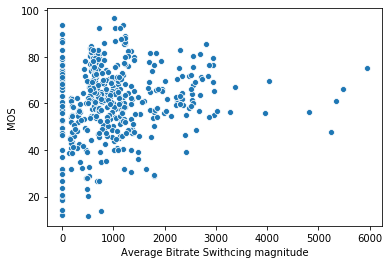

In [401]:
sns.scatterplot(y="MOS", x="Average Bitrate Swithcing magnitude", ci=None, data=full)

SpearmanrResult(correlation=0.10822992887052169, pvalue=0.02166063964763299)
SpearmanrResult(correlation=0.1333803792919883, pvalue=0.004593634315815448)


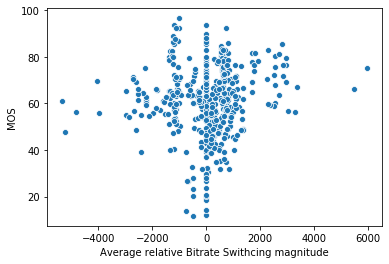

In [402]:
full["Average relative Bitrate Swithcing magnitude"] = np.nan

for index, row in full.iterrows():
    value = averageBitrateSwithcing_relative(row['bitrates'], row['Bitrate switch count'])
    full.at[index, 'Average relative Bitrate Swithcing magnitude'] = value
ax = sns.scatterplot(y="MOS", x="Average relative Bitrate Swithcing magnitude", ci=None, data=full)

print(spearmanr(full['MOS'], full['Average Bitrate Swithcing magnitude']))
print(spearmanr(full['MOS'], full['Average relative Bitrate Swithcing magnitude']))

In [403]:
#By iterating over the options, we managed to reproduce the value in the article
def Ph(bitrates, duration, inbuf):
    max_bitrate = max (bitrates)
    highest_quality_dutarion = bitrates.count(max_bitrate)
    
    #ph = 2*highest_quality_dutarion / (duration)
    ph = 2*highest_quality_dutarion / (duration-inbuf)
    
    return ph

SpearmanrResult(correlation=0.17757416164459214, pvalue=0.0001527381644023074)


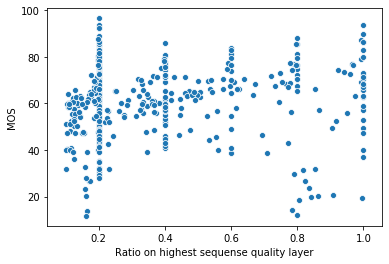

In [404]:
full["Ratio on highest sequense quality layer"] = np.nan
for index, row in full.iterrows():
    value = Ph(row['bitrates'], row['duration'], row['initial buffer time'])
    full.at[index, 'Ratio on highest sequense quality layer'] = value

ax = sns.scatterplot(y="MOS", x="Ratio on highest sequense quality layer", ci=None, data=full)
print(spearmanr(full['MOS'], full['Ratio on highest sequense quality layer']))

# What we do next

I'll finish adding the features and show you how the playtime at different quality levels affects the QoE.

I noticed an interesting thing. If you save the panda through a pick, everything works the same both before and after saving - loading.

However, if you save through xy or Excel, then while maintaining the distributions of features, the levels of column correlations may differ. Why is it so unbelievable to me.

In [410]:

full.to_pickle("Part1_tmp")